<a href="https://colab.research.google.com/github/tanviredu/PowerBI/blob/main/BRAIN_TUMOR_SEGMENTATION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

# Import libraries and setup environment

In [2]:
# import libs
import os
import re
import sys
import cv2
import glob
import time
import json
import math
import random
import imutils
import itertools
import matplotlib
import numpy as np # linear algebra
import skimage.draw
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
from tqdm import tqdm
import matplotlib.cm as cm
from skimage.io import imread
import matplotlib.pyplot as plt
import PIL.ImageDraw as ImageDraw
from imgaug import augmenters as iaa
from IPython.display import clear_output
!git clone https://github.com/rastislavkopal/brain-tumor-segmentation.git # load manually annotated data from git repo
!rm -rf brain-tumor-segmentation/.git/
clear_output()

In [3]:
DATASET_DIR = './brain-tumor-segmentation/brain_tumor_data/'
clear_output()

In [4]:
!ls brain-tumor-segmentation/brain_tumor_data

test  train  val


In [5]:
info ={}
import json
with open(DATASET_DIR+'train/annotations.json') as json_file:
    data = json.load(json_file)
SG = data.keys()
SG = list(SG)

for x in SG:
    info[x] = data[x]['filename']

In [6]:
!rm -rf ./brain-tumor-segmentation/brain_tumor_data/mask

In [7]:
import re
examples = [ Image.open(DATASET_DIR + 'train/{}'.format(x)) for x in info.values() ]
examplesSeg = list(info.keys())

## print some example images from train directory
fig = plt.figure(figsize=(10,14))

output_dir = DATASET_DIR+'mask/'
os.mkdir(output_dir)

## print segment examples for images from json annotations file
with open(DATASET_DIR+'train/annotations.json') as json_file:
    data = json.load(json_file)
    for i in range(0,len(examplesSeg)):
        filename = "{}_msk.jpg".format(info[examplesSeg[i]])
        filepath = output_dir + filename
        # load regions from json file and transform them into (x,y) coordinates
        coord = list(zip(data[examplesSeg[i]]['regions'][0]['shape_attributes']['all_points_x'],data[examplesSeg[i]]['regions'][0]['shape_attributes']['all_points_y']))
        image = Image.new("RGB", np.asarray(examples[i]).shape[0:2])
        draw = ImageDraw.Draw(image)
        draw.polygon((coord), outline='white', fill='white')
        #a = fig.add_subplot(2, 3, 3+i+1)
        #plt.imshow(image)
        image.save(filepath)
        #a.set_title('Segment for example ' + str(i))

<Figure size 1000x1400 with 0 Axes>

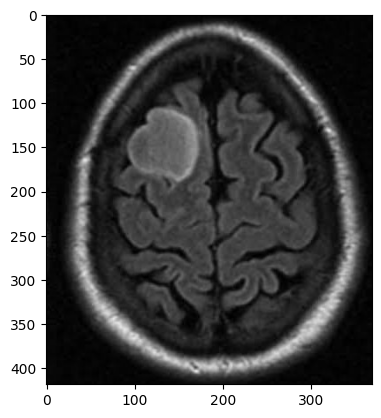

In [11]:
test1 = cv2.imread('./brain-tumor-segmentation/brain_tumor_data/train/0.jpg')
plt.imshow(test1)

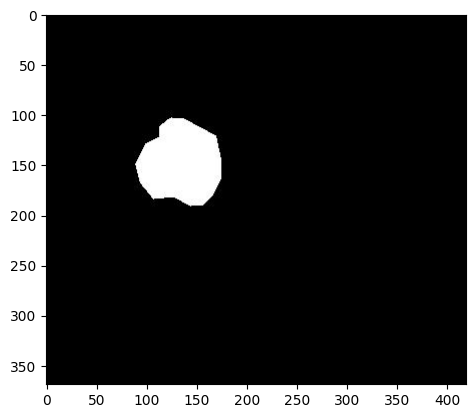

In [14]:
test2 = cv2.imread("./brain-tumor-segmentation/brain_tumor_data/mask/0.jpg_msk.jpg")
plt.imshow(test2)

**Number of data used for training**
* Bar chart of dataset size for each folder train/test/val

In [15]:
image_path = [x for x in os.listdir("./brain-tumor-segmentation/brain_tumor_data/train/")]
image_path.sort()
image_path.pop()
print(image_path)
print(len(image_path))
mask_path = [x for x in os.listdir("./brain-tumor-segmentation/brain_tumor_data/mask/")]
mask_path.sort()
print(mask_path)
print(len(mask_path))

['0.jpg', '1.jpg', '10.jpg', '100.jpg', '101.jpg', '102.jpg', '103.jpg', '105.jpg', '106.jpg', '107.jpg', '108.jpg', '109.jpg', '110.jpg', '111.jpg', '112.jpg', '113.jpg', '114.jpg', '115.jpg', '116.jpg', '117.jpg', '118.jpg', '119.jpg', '120.jpg', '121.jpg', '122.jpg', '123.jpg', '124.jpg', '125.jpg', '126.jpg', '127.jpg', '128.jpg', '129.jpg', '130.jpg', '131.jpg', '132.jpg', '133.jpg', '134.jpg', '135.jpg', '136.jpg', '137.jpg', '138.jpg', '139.jpg', '140.jpg', '141.jpg', '142.jpg', '143.jpg', '144.jpg', '145.jpg', '146.jpg', '147.jpg', '148.jpg', '149.jpg', '150.jpg', '151.jpg', '152.jpg', '153.jpg', '154.jpg', '155.jpg', '156.jpg', '157.jpg', '158.jpg', '159.jpg', '160.jpg', '161.jpg', '162.jpg', '163.jpg', '164.jpg', '165.jpg', '166.jpg', '167.jpg', '168.jpg', '169.jpg', '170.jpg', '171.jpg', '172.jpg', '173.jpg', '174.jpg', '175.jpg', '176.jpg', '177.jpg', '178.jpg', '179.jpg', '180.jpg', '181.jpg', '182.jpg', '183.jpg', '184.jpg', '185.jpg', '186.jpg', '187.jpg', '188.jpg', '18

In [16]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nv

In [17]:
import os
import glob
import cv2
import warnings
import random
import torch
import torch.nn               as nn
import pandas                 as pd
import numpy                  as np
import matplotlib.pyplot      as plt
import seaborn                as sns
import torch.optim            as optim
import torchvision.transforms as transforms
from torchviz         import make_dot
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from PIL              import Image
from torch.utils.data import Dataset
from torchvision      import transforms
from PIL              import Image
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split

In [19]:
IMAGE_SIZE = 128
BATCH_SIZE = 16
DEVICE     = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


In [20]:
class Extract:
    def get_mask(self):
        #folder_path1 = "/kaggle/input/makeup-lips-segmentation-28k-samples/set-lipstick-original/mask/"
# List all files in the folder
        files1 = ["./brain-tumor-segmentation/brain_tumor_data/mask/"+x for x in os.listdir("./brain-tumor-segmentation/brain_tumor_data/mask/")]
        files1.sort()
        files1.pop()
        #sorted_files1 = sorted(files1, key=lambda x: int(x.split('.')[0][5:]))
        self.mask = files1
        return self.mask
    def get_actual(self):
        #folder_path2 = "/kaggle/input/makeup-lips-segmentation-28k-samples/set-lipstick-original/720p/"
        # List all files in the folder
        files2 = ["./brain-tumor-segmentation/brain_tumor_data/train/"+x for x in os.listdir("./brain-tumor-segmentation/brain_tumor_data/train/")]
        files2.sort()
        files2.pop()
        #sorted_files2 = sorted(files2, key=lambda x: int(x.split('.')[0][5:]))
        self.images = files2
        return self.images
    def get_all(self):
        m = self.get_mask()
        a = self.get_actual()
        self.image_mask = list(zip(a,m))
        return self.image_mask
    def dataframe_conversion(self):
        self.series = self.get_all()
        self.df = pd.DataFrame(self.series, columns=['image_path', 'mask_path'])
        return self.df

    def plot_train_label(self,image_mask):
        image = cv2.imread(image_mask[0])
        mask = cv2.imread(image_mask[1])
        f, axarr = plt.subplots(1, 3, figsize=(5, 5))
        axarr[0].imshow(np.squeeze(image), cmap='gray', origin='lower')
        axarr[0].set_ylabel('Axial View', fontsize=14)
        axarr[0].set_xticks([])
        axarr[0].set_yticks([])
        axarr[0].set_title('CT', fontsize=14)

        axarr[1].imshow(np.squeeze(mask), cmap='jet', origin='lower')
        axarr[1].axis('off')
        axarr[1].set_title('Mask', fontsize=14)

        axarr[2].imshow(np.squeeze(image), cmap='gray', alpha=1, origin='lower')
        axarr[2].imshow(np.squeeze(mask), cmap='jet', alpha=0.5, origin='lower')
        axarr[2].axis('off')
        axarr[2].set_title('Overlay', fontsize=14)

        plt.tight_layout()
        plt.subplots_adjust(wspace=0, hspace=0)
        plt.show()

In [21]:
ETL = Extract()
images_mask = ETL.get_all()

In [23]:
class CustomImageTransform(Dataset):
    def __init__(self,image_mask,transformMethodName = None):
        self.data            = image_mask
        self.transformMethod = transformMethodName

    def __len__(self):
        return len(self.data)

    def __getitem__(self,idx):
        image_path = self.data.iloc[idx]['image_path']
        mask_path  = self.data.iloc[idx]['mask_path']

        image      = Image.open(image_path).convert("L")
        mask       = Image.open(mask_path).convert("L")

        if self.transformMethod:
            image  = self.transformMethod(image)
            mask   = self.transformMethod(mask)

        return image,mask

In [24]:
class ConvBlock(nn.Module):
    def __init__(self,input_channel,out_channel,dropout):
        super(ConvBlock,self).__init__()
        self.CONV2D1    = nn.Conv2d(input_channel,out_channel,kernel_size=3,padding=1)
        self.BATCHNORN1 = nn.BatchNorm2d(out_channel)
        self.RELU1      = nn.ReLU()
        self.DROPOUT    = nn.Dropout(dropout)
        self.CONV2D2    = nn.Conv2d(out_channel,out_channel,kernel_size=3,padding=1)
        self.BATCHNORN2 = nn.BatchNorm2d(out_channel)
        self.RELU2      = nn.ReLU()

    def forward(self,x):
        """ IN CONV2D PYTORCH MODULE YOU DONT NEED TO GIVE THE OUTPUT CHANNEL PARAMETER VALUE
            BUT THE PARAMETER HAVE TO BE THERE"""
        x = self.CONV2D1(x)
        x = self.BATCHNORN1(x)
        x = self.RELU1(x)
        x = self.DROPOUT(x)
        x = self.CONV2D2(x)
        x = self.BATCHNORN2(x)
        x = self.RELU2(x)
        return x

In [25]:
class ENCODER(nn.Module):
    def __init__(self,input_channel,out_channel,dropout):
        super(ENCODER,self).__init__()
        self.CONV2D1  = ConvBlock(input_channel,out_channel,dropout)
        self.MAXPOOL1 = nn.MaxPool2d((2,2))
        self.DROPOUT1 = nn.Dropout(dropout)

    def forward(self,x):
        x = self.CONV2D1(x)
        p = self.MAXPOOL1(x)
        p = self.DROPOUT1(p)

        return x,p

In [27]:
class DECODER(nn.Module):
    def __init__(self,input_channel,out_channel,dropout):
        super(DECODER,self).__init__()
        self.CONVTRANSPOSE1 = nn.ConvTranspose2d(input_channel,out_channel,stride=2,kernel_size=2)
        ## THE CONVTRANSPOSE UPSAMPLES THE LAYER BY 2 AND SAVE IT TO THE OUTCHANNEL
        ## THATHS WHY FOR FURTHER CONVOLUTION WE MULTIPLY THE OUTCHANNEL BY 2
        self.CONV2D1        = ConvBlock(out_channel*2,out_channel,dropout)
        self.DROPOUT        = nn.Dropout(dropout)

    def forward(self,x,skip):
        x = self.CONVTRANSPOSE1(x)
        x = torch.cat([x,skip],dim=1)
        x = self.CONV2D1(x)
        x = self.DROPOUT(x)


        return x

In [28]:
class UNET(nn.Module):
    def __init__(self,input_channel = 1): ## GRAYSCALE IMAGE
        super().__init__()
        self.ENCODER1  = ENCODER(input_channel,64,0.07)
        self.ENCODER2  = ENCODER(64,128,0.08)
        self.ENCODER3  = ENCODER(128,256,0.09)
        self.ENCODER4  = ENCODER(256,512,0.01)
        self.CONVBLOCK = ConvBlock(512,1024,0.11)
        self.DECODER1  = DECODER(1024,512,0.1)
        self.DECODER2  = DECODER(512,256,0.09)
        self.DECODER3  = DECODER(256,128,0.08)
        self.DECODER4  = DECODER(128,64,0.07)
        self.CLS       = nn.Conv2d(64,1,kernel_size=1,padding=0)
        self.ACTFN     = nn.Sigmoid()

    def forward(self,x):
        x1,p1   = self.ENCODER1(x)
        x2,p2   = self.ENCODER2(p1)
        x3,p3   = self.ENCODER3(p2)
        x4,p4   = self.ENCODER4(p3)

        x5      = self.CONVBLOCK(p4)

        x6      = self.DECODER1(x5,x4)
        x7      = self.DECODER2(x6,x3)
        x8      = self.DECODER3(x7,x2)
        x9      = self.DECODER4(x8,x1)

        x_FINAL = self.CLS(x9)
        x_FINAL = self.ACTFN(x_FINAL)

        return x_FINAL

In [41]:
class Trainer:
    def __init__(self, model, num_epoch, optimizer, criterion, device):
        self.NUM_EPOCH = num_epoch
        self.OPTIMIZER = optimizer
        self.CRITERION = criterion
        self.MODEL = model
        self.device = device
        self.LOG_INTRVL = 15

        self.TRAIN_LOSSES = []
        self.VAL_LOSSES = []
        self.TRAIN_DICES = []
        self.VAL_DICES = []

        self.BEST_MODEL = None
        self.BEST_DICE = 0
        self.BEST_EPOCH = 0

    def DICE_COEFF(self, predicted, target, smooth=1e-5):
        INTERSECTION = torch.sum(predicted * target)
        UNION = torch.sum(predicted) + torch.sum(target)
        DICE = (2. * INTERSECTION + smooth) / (UNION + smooth)
        return DICE

    def IOU(self, pred_mask, true_mask):
        INTERSECTION = torch.logical_and(pred_mask, true_mask).sum().item()
        UNION = torch.logical_or(pred_mask, true_mask).sum().item()
        IOU_SCORE = INTERSECTION / UNION if UNION != 0 else 0.0
        return IOU_SCORE

    def train(self, train_loader, val_loader):
        for epoch in range(self.NUM_EPOCH):
            TRAIN_LOSS = 0.0
            VAL_LOSS = 0.0
            TRAIN_DICE = 0.0
            VAL_DICE = 0.0

            for i, (images, masks) in enumerate(train_loader):
                images, masks = images.to(self.device), masks.to(self.device)
                self.MODEL.train()
                self.OPTIMIZER.zero_grad()
                outputs = self.MODEL(images)
                loss = self.CRITERION(outputs, masks)
                dice = self.DICE_COEFF(outputs, masks)
                loss.backward()
                self.OPTIMIZER.step()
                TRAIN_LOSS += loss.item()
                TRAIN_DICE += dice
                print(f'Epoch [{epoch + 1}/{self.NUM_EPOCH}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}, Dice Coef: {dice:.4f}')

            # Validation
            self.MODEL.eval()
            with torch.no_grad():
                for images, masks in val_loader:
                    images, masks = images.to(self.device), masks.to(self.device)
                    outputs = self.MODEL(images)
                    VAL_LOSS += self.CRITERION(outputs, masks).item()
                    VAL_DICE += self.DICE_COEFF(outputs, masks)

            avg_train_loss = TRAIN_LOSS / len(train_loader)
            avg_val_loss = VAL_LOSS / len(val_loader)
            avg_train_dice = TRAIN_DICE / len(train_loader)
            avg_val_dice = VAL_DICE / len(val_loader)

            self.TRAIN_LOSSES.append(avg_train_loss)
            self.VAL_LOSSES.append(avg_val_loss)
            self.TRAIN_DICES.append(avg_train_dice)
            self.VAL_DICES.append(avg_val_dice)


    def get_metrics(self):
        return {
            'train_losses': self.TRAIN_LOSSES,
            'val_losses': self.VAL_LOSSES,
            'train_dices': self.TRAIN_DICES,
            'val_dices': self.VAL_DICES,
            'best_dice': self.BEST_DICE,
            'best_epoch': self.BEST_EPOCH
        }

In [42]:
class LossFunctions:
    @staticmethod
    def dice_coef_loss(inputs, target):
        smooth = 1e-6
        intersection = 2.0 * (target * inputs).sum() + smooth
        union = target.sum() + inputs.sum() + smooth
        return 1 - (intersection / union)


    @staticmethod
    def bce_dice_loss(inputs, target):
        dice_score = LossFunctions.dice_coef_loss(inputs, target)
        bce_loss = nn.BCELoss()
        bce_score = bce_loss(inputs, target)
        return bce_score + dice_score

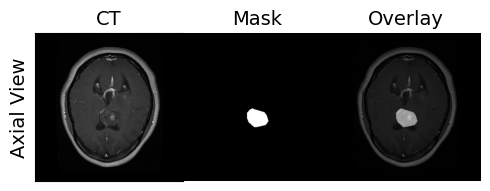

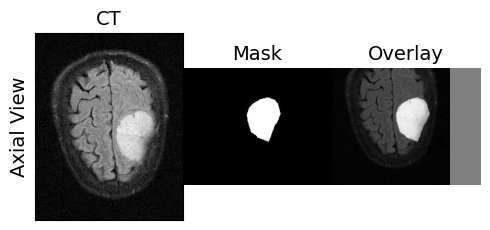

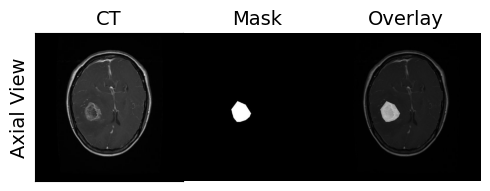

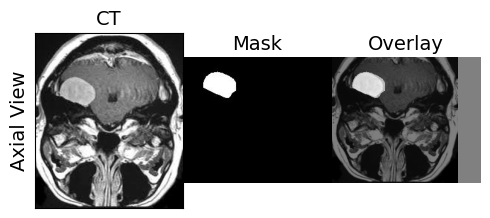

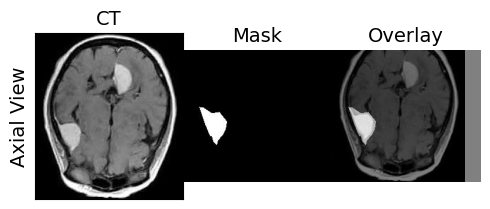

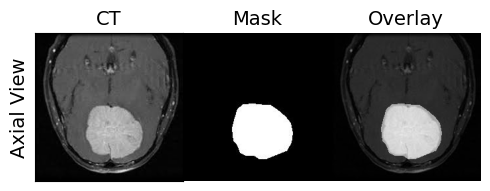

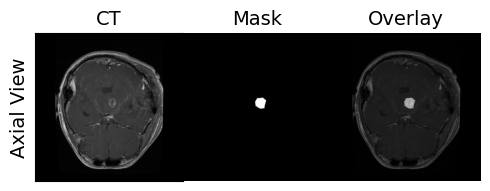

In [43]:
random_image = random.sample(range(20), 7)
for image in random_image:
    ETL.plot_train_label(images_mask[image])

In [44]:
dataset = ETL.dataframe_conversion()
dataset

,image_path,mask_path
0,./brain-tumor-segmentation/brain_tumor_data/tr...,./brain-tumor-segmentation/brain_tumor_data/ma...
1,./brain-tumor-segmentation/brain_tumor_data/tr...,./brain-tumor-segmentation/brain_tumor_data/ma...
2,./brain-tumor-segmentation/brain_tumor_data/tr...,./brain-tumor-segmentation/brain_tumor_data/ma...
3,./brain-tumor-segmentation/brain_tumor_data/tr...,./brain-tumor-segmentation/brain_tumor_data/ma...
4,./brain-tumor-segmentation/brain_tumor_data/tr...,./brain-tumor-segmentation/brain_tumor_data/ma...
...,...,...
196,./brain-tumor-segmentation/brain_tumor_data/tr...,./brain-tumor-segmentation/brain_tumor_data/ma...
197,./brain-tumor-segmentation/brain_tumor_data/tr...,./brain-tumor-segmentation/brain_tumor_data/ma...
198,./brain-tumor-segmentation/brain_tumor_data/tr...,./brain-tumor-segmentation/brain_tumor_data/ma...
199,./brain-tumor-segmentation/brain_tumor_data/tr...,./brain-tumor-segmentation/brain_tumor_data/ma...


In [45]:
train_transforms = transforms.Compose([
    transforms.Resize([IMAGE_SIZE, IMAGE_SIZE]),
    transforms.ToTensor(),
])

val_transforms = transforms.Compose([
    transforms.Resize([IMAGE_SIZE, IMAGE_SIZE]),
    transforms.ToTensor(),
])

In [46]:
train, test= train_test_split(dataset, test_size=0.25)

In [47]:
train_dataset = CustomImageTransform(train, train_transforms)
test_dataset = CustomImageTransform(test, val_transforms)

In [48]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [49]:
unet = UNET(1).to(DEVICE)

In [50]:
LR           = 0.0001
OPTIMIZER    = optim.Adam(unet.parameters(),lr=LR)
trainer      = Trainer(model=unet,num_epoch=120,optimizer=OPTIMIZER,criterion=LossFunctions.bce_dice_loss,device=DEVICE)

In [51]:
trainer.train(train_dataloader,test_dataloader)

Epoch [1/120], Step [1/10], Loss: 1.4800, Dice Coef: 0.0616
Epoch [1/120], Step [2/10], Loss: 1.4586, Dice Coef: 0.0551
Epoch [1/120], Step [3/10], Loss: 1.4036, Dice Coef: 0.0898
Epoch [1/120], Step [4/10], Loss: 1.4351, Dice Coef: 0.0575
Epoch [1/120], Step [5/10], Loss: 1.4052, Dice Coef: 0.0830
Epoch [1/120], Step [6/10], Loss: 1.3908, Dice Coef: 0.0888
Epoch [1/120], Step [7/10], Loss: 1.3957, Dice Coef: 0.0829
Epoch [1/120], Step [8/10], Loss: 1.4094, Dice Coef: 0.0683
Epoch [1/120], Step [9/10], Loss: 1.3649, Dice Coef: 0.0930
Epoch [1/120], Step [10/10], Loss: 1.3534, Dice Coef: 0.0974
Epoch [2/120], Step [1/10], Loss: 1.3806, Dice Coef: 0.0770
Epoch [2/120], Step [2/10], Loss: 1.3386, Dice Coef: 0.1018
Epoch [2/120], Step [3/10], Loss: 1.3014, Dice Coef: 0.1206
Epoch [2/120], Step [4/10], Loss: 1.3506, Dice Coef: 0.0790
Epoch [2/120], Step [5/10], Loss: 1.2940, Dice Coef: 0.1115
Epoch [2/120], Step [6/10], Loss: 1.2853, Dice Coef: 0.1215
Epoch [2/120], Step [7/10], Loss: 1.307

In [52]:
metrics = trainer.get_metrics()

In [53]:
def to_numpy(tensor):
    # Move tensor to CPU and convert to NumPy array
    return tensor.cpu().detach().item()

def plot_metrics(metrics):
    num_epochs = len(metrics['train_losses'])
    epochs = np.arange(1, num_epochs + 1)

    # Convert tensors to NumPy arrays
    train_losses_np = metrics['train_losses']
    val_losses_np = metrics['val_losses']
    train_dices_np = [to_numpy(dice) for dice in metrics['train_dices']]
    val_dices_np = [to_numpy(dice) for dice in metrics['val_dices']]
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses_np, label='Train Loss')
    plt.plot(epochs, val_losses_np, label='Val Loss')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Dice Coefficients
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_dices_np, label='Train Dice')
    plt.plot(epochs, val_dices_np, label='Val Dice')
    plt.title('Training and Validation Dice Coefficients')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.legend()

    plt.tight_layout()
    plt.show()

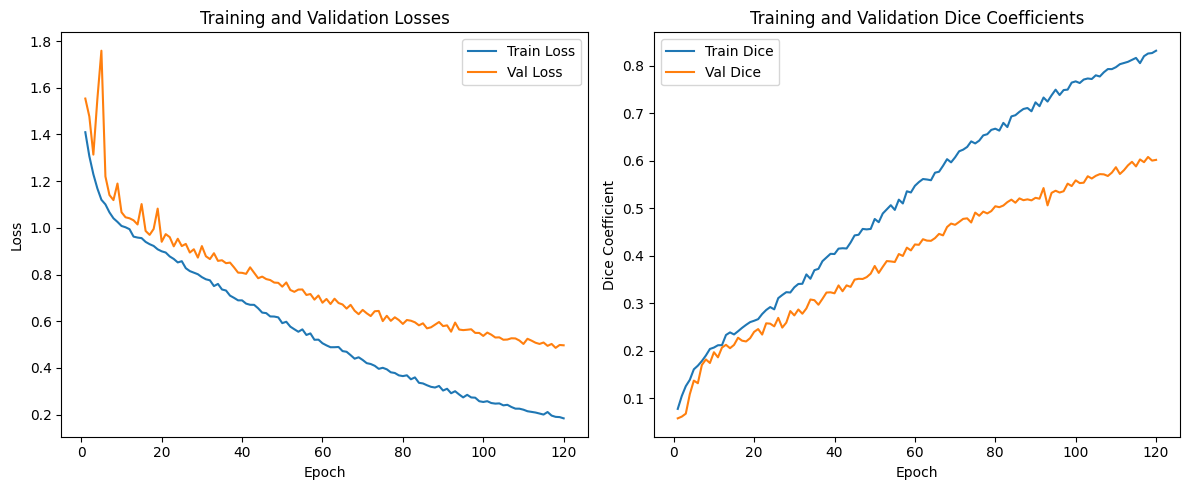

In [54]:
plot_metrics(metrics)

In [55]:
import matplotlib.pyplot as plt
import numpy as np

def to_numpy(tensor):
    # Move tensor to CPU and convert to NumPy array
    return tensor.cpu().detach().numpy()

def threshold_prediction(predicted, threshold=0.5):
    # Threshold predicted values
    predicted[predicted < threshold] = 0
    predicted[predicted >= threshold] = 1
    return predicted

def plot_subplots(image, mask, predicted, threshold=0.5):
    # Convert tensors to NumPy arrays
    image_np, mask_np, predicted_np = map(to_numpy, (image, mask, predicted))

    # Threshold the predicted values
    predicted_np_thresholded = threshold_prediction(predicted_np, threshold)

    fig, axes = plt.subplots(1, 3, figsize=(10, 5))  # Adjust figsize as needed

    # Plot Image, Mask, Predicted, and Thresholded Predicted
    titles = ['Image', 'Mask', 'Predicted']
    for ax, data, title in zip(axes, [image_np, mask_np, predicted_np, predicted_np_thresholded], titles):
        ax.imshow(data.squeeze(), cmap='gray' if 'Mask' in title else 'gray')
        ax.set_title(title)
        ax.axis('off')

    plt.show()

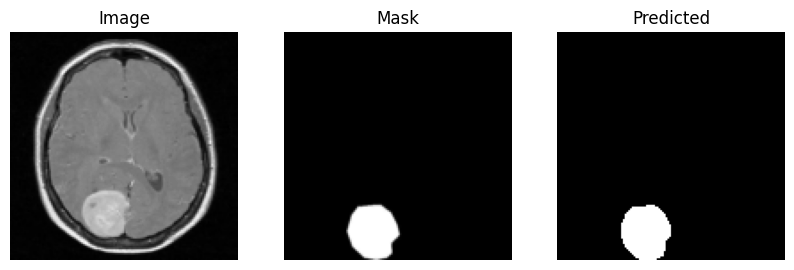

In [56]:
import matplotlib.pyplot as plt
from skimage.measure import label
from PIL import Image
import cv2

i = random.randint(20,40)
image = train_dataset[i][0]
mask = train_dataset[i][1]
im = image.to(DEVICE)
pred = unet(im.unsqueeze(0))
pred = pred.squeeze()
# plot are

plot_subplots(im, mask, pred)

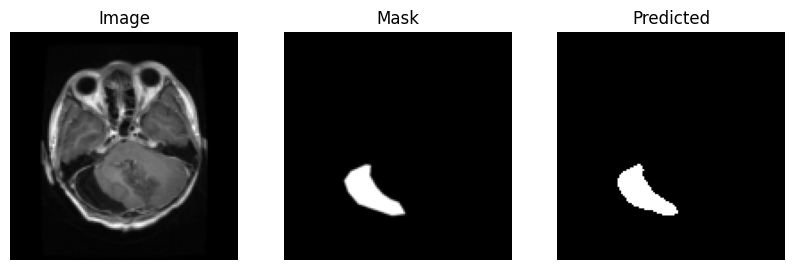

(1, 128, 128)


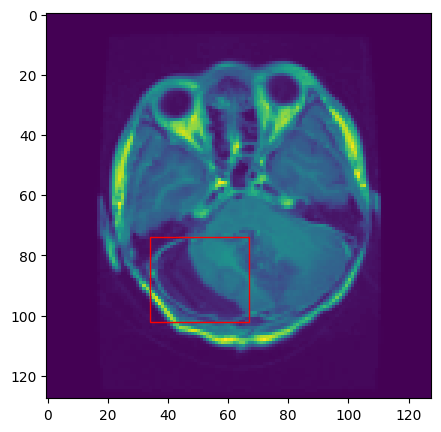

In [57]:
i = random.randint(20,40)
image = train_dataset[i][0]
mask = train_dataset[i][1]
im = image.to(DEVICE)
pred = unet(im.unsqueeze(0))
pred = pred.squeeze()
# plot are

plot_subplots(im, mask, pred)
image = np.array(image)
image.squeeze()
print(image.shape)

binary_matrix = (pred > 0.5).to(torch.uint8)

binary_matrix = binary_matrix.cpu().numpy()
mask = binary_matrix
label_image = label(mask)
bbox = label_image.nonzero()
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.imshow(image.squeeze())
rect = plt.Rectangle((bbox[1].min(), bbox[0].min()), bbox[1].max()-bbox[1].min(), bbox[0].max()-bbox[0].min(), linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()